Copy of v7

In [1]:
VAEversion='71'

In [2]:
from glob import glob
import os, sys, scipy, pickle
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

from prettytable import PrettyTable

In [3]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.12/06


Using TensorFlow backend.


In [4]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import layers as KL
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, ModelCheckpoint
from keras.constraints import max_norm
import keras
print keras.__version__

2.2.2


In [5]:
do_training = 0

# Get the samples

In [6]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)

In [7]:
data_folder = '../../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'Zll', 'ttbar']
BSM_samples = ['Ato4l', 'leptoquark', 'hToTauTau', 'hChToTauNu']

N_train_max = int(9e6)
training_split_fraction = 0.5

In [8]:
fraction = np.array([0.592, 0.338, 0.067, 0.003])

raw_sample = {}
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_sample.npy')
#     np.random.shuffle(raw_sample[n])
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
if TrainSamplesName[i_min]=='qcd':
    print 'QCD is limiting, using it for both val and split'
    N_train = min(N_train_max, l[i_min]/fraction[i_min])
else:
    N_train = min(N_train_max, training_split_fraction*l[i_min]/fraction[i_min])

if N_train < N_train_max:
    print 'Limiting stat. sample:', TrainSamplesName[i_min]
else:
    print 'Sample available satisfying '

N_val = N_train*(1-training_split_fraction)/training_split_fraction - 1
print 'Expected {:.2f}M train'.format(N_train/1.0e6)
print 'Expected {:.2f}M val'.format(N_val/1.0e6)

QCD is limiting, using it for both val and split
Limiting stat. sample: qcd
Expected 3.45M train
Expected 3.45M val


In [9]:
x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    N_val_aux = int(N_val * fraction[i])
    if TrainSamplesName[i_min]=='qcd' and n == 'qcd':
        print 'QCD is limiting, using it for both val and split'
        np.random.shuffle(raw_sample[n])
        x_val_s[n] = raw_sample[n][:N_val_aux, sel]
    elif N_train_aux+N_val_aux < raw_sample[n].shape[0]:
        x_val_s[n] = raw_sample[n][N_train_aux : N_train_aux+N_val_aux, sel]
    else:
        print 'Error', n
        continue
    table.add_row([n, raw_sample[n].shape[0], x_train_s[n].shape[0], x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['Zll'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['Zll'], x_val_s['ttbar']))

print 'Tot training {:.2f} M'.format(x_train.shape[0]/1.0e6)
print 'Tot val {:.2f} M'.format(x_val.shape[0]/1.0e6)

QCD is limiting, using it for both val and split
+--------+----------+---------+---------+
| Sample | Evts tot |  Train  |   Val   |
+--------+----------+---------+---------+
|  Wlnu  | 8000082  | 2042566 | 2042565 |
|  qcd   | 1166195  | 1166195 | 1166194 |
|  Zll   | 1777383  |  231168 |  231168 |
| ttbar  | 5001726  |  10350  |  10350  |
+--------+----------+---------+---------+
Tot training 3.45 M
Tot val 3.45 M


# Start the VAE declaration

In [10]:
original_dim = x_train.shape[1]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
weight_KL_loss = 0.3

In [11]:
x_DNN_input = Input(shape=(original_dim,), name='Input')
hidden_1 = Dense(intermediate_dim, activation=act_fun, name='Encoder_h1')
aux = hidden_1(x_DNN_input)
hidden_2 = Dense(intermediate_dim, activation=act_fun, kernel_constraint=max_norm(kernel_max_norm), name='Encoder_h2')
# hidden_3 = Dense(intermediate_dim, activation=act_fun)(hidden_2)
aux = hidden_2(aux)

L_z_mean = Dense(latent_dim, name='Latent_mean')
T_z_mean = L_z_mean(aux)

L_z_sigma_preActivation = Dense(latent_dim, name='Latent_sigma_h')
aux = L_z_sigma_preActivation(aux)
L_z_sigma = Lambda(InverseSquareRootLinearUnit, name='Latent_sigma')
T_z_sigma = L_z_sigma(aux)

In [12]:
L_z_latent = Lambda(sampling, name='Latent_sampling')([T_z_mean, T_z_sigma])
decoder_h1 = Dense(intermediate_dim, 
                   activation=act_fun, 
                   kernel_constraint=max_norm(kernel_max_norm), 
                   name='Decoder_h1')(L_z_latent)

decoder_h2 = Dense(intermediate_dim, activation=act_fun, name='Decoder_h2')(decoder_h1)
# decoder_h3 = Dense(intermediate_dim, activation=act_fun)(decoder_h2)
L_par1 = Dense(original_dim, name='Output_par1')(decoder_h2)

L_par2_preActivation = Dense(Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss, name='par2_h')(decoder_h2)
L_par2 = Lambda(InverseSquareRootLinearUnit, name='Output_par2')(L_par2_preActivation)

L_par3_preActivation = Dense(Nf_lognorm, name='par3_h')(decoder_h2)
L_par3 = Lambda(ClippedTanh, name='Output_par3')(L_par3_preActivation)

Create Prior Layer

In [13]:
fixed_input = Lambda(SmashTo0)(x_DNN_input)
h1_prior = Dense(1,
                 kernel_initializer='zeros', 
                 bias_initializer='ones', 
                 trainable=False, 
                 name='h1_prior'
                )(fixed_input)

L_prior_mean = Dense(latent_dim, 
                     kernel_initializer='zeros', 
                     bias_initializer='zeros', 
                     trainable=True, 
                     name='L_prior_mean'
                    )(h1_prior)

L_prior_sigma_preActivation = Dense(latent_dim, 
                                    kernel_initializer='zeros', 
                                    bias_initializer='ones', 
                                    trainable=True,
                                    name='L_prior_sigma_preAct'
                                   )(h1_prior)
L_prior_sigma = Lambda(InverseSquareRootLinearUnit, name='L_prior_sigma')(L_prior_sigma_preActivation)

Custom loss function

In [14]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

In [15]:
def RecoProb_forVAE(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = K.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma) 
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma))
                           )
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_gauss] - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    # Positive Gaussian distributed variables
    mu = par1[:,N:N+Nf_Pgauss]
    sigma = par2[:,N:N+Nf_Pgauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_Pgauss] - mu, sigma)

    sqrt2 = 1.4142135624
    aNorm = 1 + 0.5*(1 + K.tf.erf(K.tf.divide(- mu, sigma)/sqrt2))
    
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x) - K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_Pgauss
    
    # Positive Discrete Gaussian distributed variables
    mu = par1[:,N:N+Nf_PDgauss]
    sigma = par2[:,N:N+Nf_PDgauss]
    norm_xp = K.tf.divide(x[:,N:N+Nf_PDgauss] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,N:N+Nf_PDgauss] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))
    
    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_PDgauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*K.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -K.tf.where(K.equal(x[:, N: N+Nf_binomial],1), K.log(p), K.log(1-p))
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + K.tf.where(K.tf.greater(aux, 0), aux, K.tf.divide(aux, K.sqrt(1+K.square(aux))))
    single_NLL = K.tf.lgamma(x[:, N:]+1) - x[:, N:]*K.log(mu) + mu
    nll_loss += K.sum(single_NLL, axis=-1)
    
    return nll_loss

In [16]:
class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs    
        return RecoProb_forVAE(x, par1, par2, par3)
    
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)
    
def IdentityLoss(y_train, NETout):
    return K.mean(NETout)

In [17]:
L_RecoProb = CustomRecoProbLayer(name='RecoNLL')([x_DNN_input, L_par1, L_par2, L_par3])
L_KLLoss = CustomKLLossLayer(name='KL')([T_z_mean, T_z_sigma, L_prior_mean, L_prior_sigma])
# vae = Model(inputs=x_DNN_input, outputs=[L_KLLoss, L_RecoProb])

# vae.compile(optimizer='adam', 
#             loss=[IdentityLoss, IdentityLoss], 
#             loss_weights=[weight_KL_loss, 1.]
#             )

# print vae.summary()

In [18]:
from keras.models import load_model
custom_objects = {
    'original_dim': x_train.shape[1],
    'latent_dim': latent_dim,
    'intermediate_dim': intermediate_dim,
    'act_fun': act_fun,
    'Nf_lognorm' : Nf_lognorm,
    'Nf_gauss' : Nf_gauss,
    'Nf_Pgauss' : Nf_Pgauss,
    'Nf_PDgauss' : Nf_PDgauss,
    'Nf_binomial' : Nf_binomial,
    'Nf_poisson' : Nf_poisson,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    'IdentityLoss' : IdentityLoss
}

vae = load_model('VAE_all-in-one_v'+VAEversion+'.h5', custom_objects=custom_objects)
print 'Loaded'

Loaded


/Users/olmo/programs/miniconda2/lib/python2.7/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Build encoder and decoder

Get prior means and variance array

In [19]:
Prior_Dumper = load_model('prior_all-in-one_v'+VAEversion+'.h5', custom_objects=custom_objects)
    
aux = Prior_Dumper.predict(np.zeros((1, original_dim)))
mu_prior = aux[0][0]
sigma_prior = aux[1][0]

print mu_prior
print sigma_prior

[ 1.6673734 -2.1821275  0.977541   9.15674  ]
[4.3814697 1.9533033 8.003387  6.381446 ]


/Users/olmo/programs/miniconda2/lib/python2.7/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
encoder = load_model('encoder_all-in-one_v'+VAEversion+'.h5', custom_objects=custom_objects)
autoencoder = load_model('autoencoder_all-in-one_v'+VAEversion+'.h5', custom_objects=custom_objects)

# Validation

Gather the signal data

In [21]:
x_sig = {}
for n in BSM_samples+TrainSamplesName:
    s = np.load(data_folder+n+'_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

## Recostruction sum of pdf

In [22]:
x_axis_label = [ '$S_{T}$ [GeV]', 'Jets Mass [GeV]',
                'Muons $P_{T}$ [GeV]', 'Muons Mass [GeV]',
                'Electrons $P_{T}$ [GeV]', 'Electrons Mass [GeV]',
                'Lep $P_{T}$ [GeV]', 'ChPFIso', 'GammaPFIso', 'NeuPFIso',
                
#                 'METp [GeV]', 'METo [GeV]',
                '$p_{T \parallel}^{miss}$ [GeV]', '$p_{T \perp}^{miss}$ [GeV]',
                
                '$M_{T}$ [GeV]',
                
                'Muons number', 'Jets number', 'b-tagged jets number', 'Electrons number',
                
                'Lep Charge [e]','IsEle',
                
                'Charged Had number', 'Neutral Had number']

In [23]:
pars_ae_val = autoencoder.predict(x_val, batch_size=2000)

HT
allJetMass
allMuPt
allMuMass
allElePt
allEleMass
LepPt
LepIsoCh
LepIsoGamma
LepIsoNeu
METp
METo
MT
nMu
nJets
bJets
nEle
LepCharge
LepIsEle
nChHad
nNeuHad


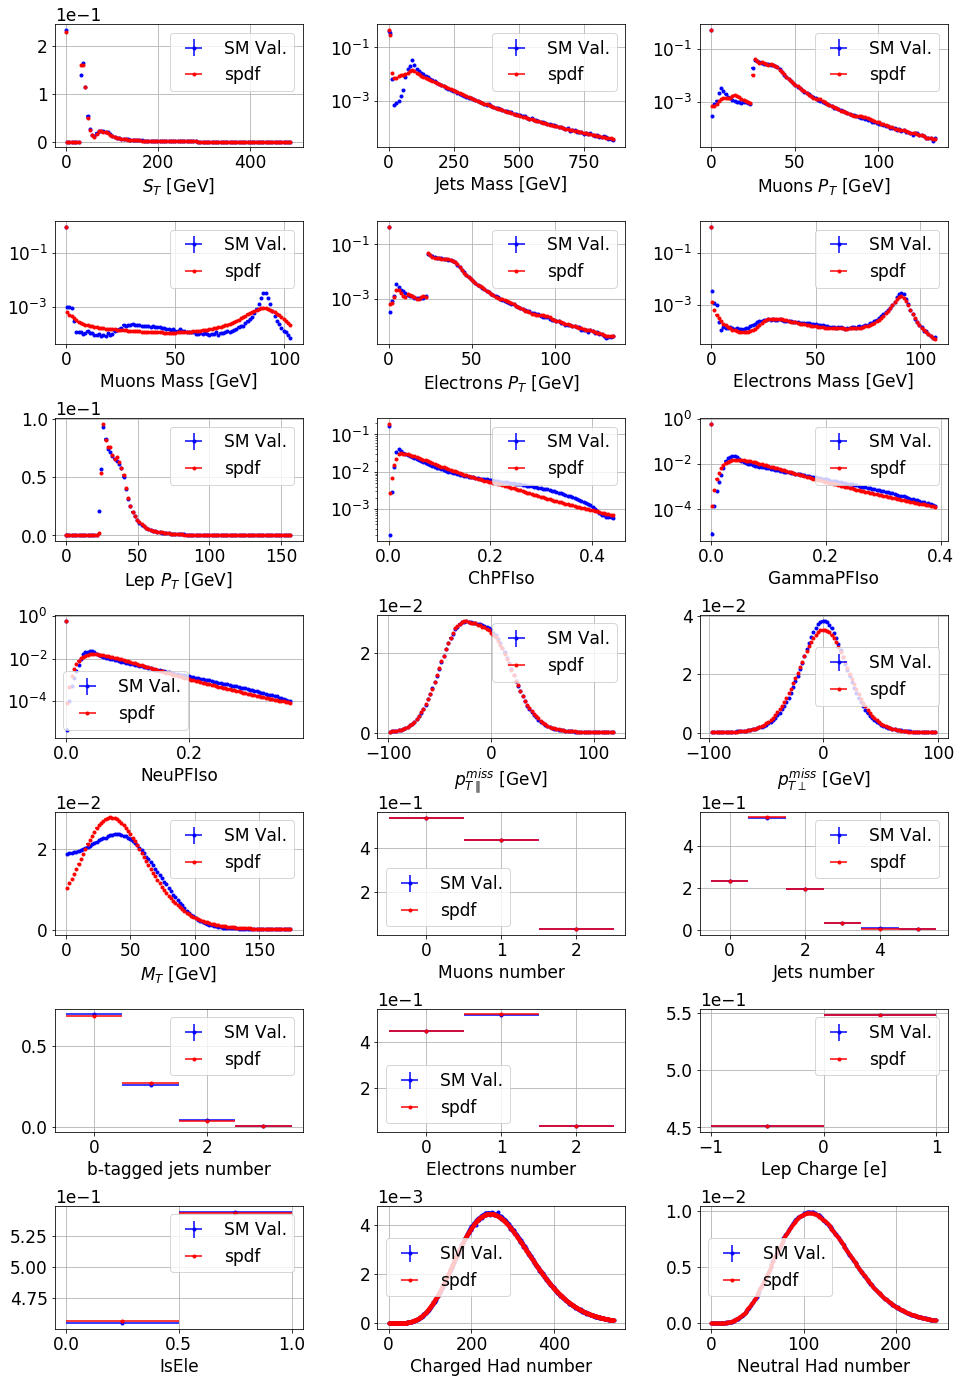

In [37]:
matplotlib.rcParams.update({'font.size': 17})
N_rows = 7
N_column = 3
f, ax_arr = plt.subplots(N_rows, N_column, figsize=(16, 24))
N_bins = 100

N_max = x_val.shape[0]

for i,hlf_name in enumerate(active_hlf_features):
    print hlf_name
    
    #Plot distribution of the variable
    x_aux = x_val[:N_max, i]
    if i < Nf_lognorm:
        histo_range = (0, np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        if np.sum(bin_edges>clip_x_to0) > 0:
            i_aux = np.argmin(bin_edges<clip_x_to0)
            bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[i_aux:]))
        else:
            bin_edges = np.array([0, clip_x_to0])
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
        bin_width[0] = 1.

        mu_vec = pars_ae_val[0][:N_max, i]
        sigma_vec = pars_ae_val[1][:N_max, i]
        f_vec = pars_ae_val[2][:N_max, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:N_max, i]
        sigma_vec = pars_ae_val[1][:N_max, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:N_max, i]
        sigma_vec = pars_ae_val[1][:N_max, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_Pgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:N_max, i]
        sigma_vec = pars_ae_val[1][:N_max, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_PDgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss + Nf_binomial:
        bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        p = 0.5*(1+0.98*np.tanh(pars_ae_val[0][:N_max, i]))

        spdf_bin_content = np.zeros_like(bincenters)
        spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
        spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
    else:
        Nmax = int(np.percentile(x_aux, 99.5))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        aux = pars_ae_val[0][:N_max, i]
        mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
        spdf_bin_content = sum_of_possion(bincenters, mu_vec)


    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
        
    ax_arr[i/N_column, i%N_column].errorbar(bincenters, 
                          bin_content.astype(float)/np.sum(bin_content), 
                          xerr=bin_width/2., 
                          yerr=np.sqrt(bin_content)/np.sum(bin_content),
                          fmt='.b', label='SM Val.')
    ax_arr[i/N_column, i%N_column].errorbar(bincenters, 
                          spdf_bin_content/np.sum(spdf_bin_content), 
                          xerr=bin_width/2., 
                          fmt='.r', label='spdf')
    ax_arr[i/N_column, i%N_column].ticklabel_format(axis='y', style='sci', scilimits=(0.01,100))
    ax_arr[i/N_column, i%N_column].grid()
    ax_arr[i/N_column, i%N_column].set_xlabel(x_axis_label[i])        
    ax_arr[i/N_column, i%N_column].legend(loc='best')
    
    if hlf_name.startswith('LepIso') or hlf_name.startswith('all'):
        ax_arr[i/N_column, i%N_column].set_yscale('log')
        
f.subplots_adjust(hspace=0.6, wspace=0.3)
f.savefig('../../fig/paper_fig/SMMix_SumOfPdfs_v'+VAEversion+'_newsize.pdf', bbox_inches='tight')        
plt.show()

# Test Statistics with Losses

In [22]:
print 'SMMix', x_train.shape
out = vae.predict(x_train, batch_size=2000)
loss_train = np.column_stack((weight_KL_loss*out[0]+out[1], out[1], out[0])).T

loss_sig = {}
for n in x_sig.keys():
    print n, x_sig[n].shape
    aux = vae.predict(x_sig[n], batch_size=2000)
    loss_sig[n] = np.column_stack((weight_KL_loss*aux[0]+aux[1], aux[1], aux[0])).T

SMMix (3450279, 21)
hToTauTau (344917, 21)
Zll (1777383, 21)
Ato4l (652070, 21)
Wlnu (8000082, 21)
hChToTauNu (339018, 21)
qcd (1166195, 21)
leptoquark (583043, 21)
ttbar (5001726, 21)


In [23]:
BSM_labels = {'Ato4l':r'$A\to 4\ell$', 
              'leptoquark':r'$LQ$', 
              'hToTauTau':r'$h^{0}\to \tau\tau$', 
              'hChToTauNu':r'$h^{\pm}\to \tau\nu$'}

/Users/olmo/programs/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


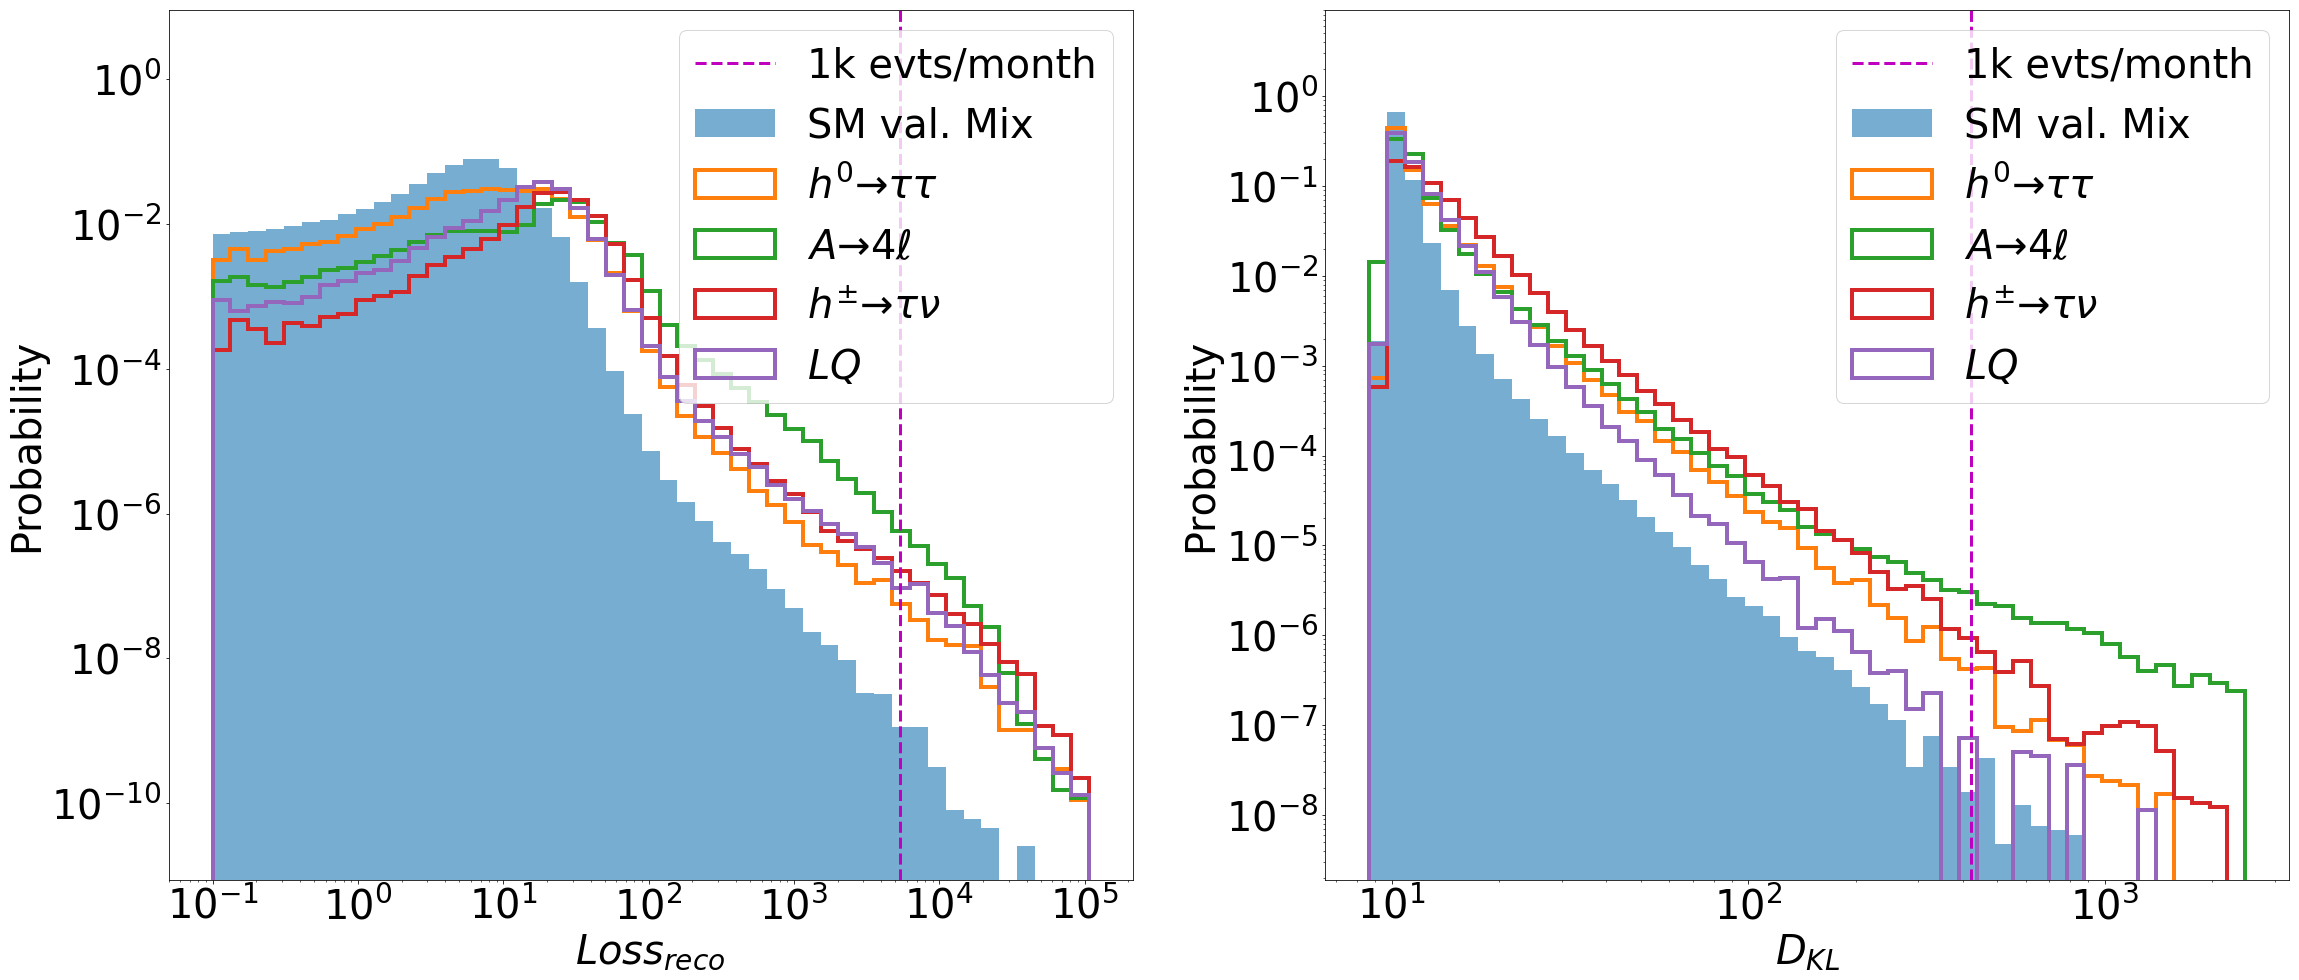

In [25]:
matplotlib.rcParams.update({'font.size': 40})
histos = []
canvases = []
x_axis_titles = ['Loss Tot', '$Loss_{reco}$', '$D_{KL}$']

eff_SMMix = 5.38E-06

f, ax_arr = plt.subplots(1, 2, figsize=(38, 16))

for loss_piece in range(1,3):
    up_end = 3*np.max(loss_train[loss_piece])
    dwn_end = max(1e-1, np.min(loss_train[loss_piece]))
    bins = np.logspace(start=np.log10(dwn_end), stop=np.log10(up_end), num=50)
    
    i_ax = loss_piece-1
    ax_arr[i_ax].hist(loss_train[loss_piece], bins=bins, normed=True, label='SM val. Mix', alpha=0.6)
    
    for n, loss in loss_sig.iteritems():
        if n in BSM_labels.keys():
            ax_arr[i_ax].hist(loss[loss_piece], 
                              bins=bins, normed=True, 
                              histtype='step',
                              lw=4,
                              label=BSM_labels[n])
            
    ax_arr[i_ax].set_yscale('log')
    ax_arr[i_ax].set_xscale('log')
    ax_arr[i_ax].set_xlabel(x_axis_titles[loss_piece])
    ax_arr[i_ax].set_ylabel('Probability')
    ax_arr[i_ax].set_ylim(ax_arr[i_ax].set_ylim()[0], 9)
    
    q = np.percentile(loss_train[loss_piece], 100*(1-eff_SMMix))
    ys = list(ax_arr[i_ax].set_ylim())
    ax_arr[i_ax].plot([q, q], ys, lw = 3, color='m', ls='--', label='1k evts/month')
    
    ax_arr[i_ax].legend(loc='best')
    
f.subplots_adjust(wspace=0.2)
# f.savefig('../../fig/paper_fig/LossesPDF_v'+VAEversion+'.png', bbox_inches='tight')

In [26]:
SM_evts_per_month = 1000
SM_tot_xsec = 37.205e6 #fb

lumi_per_yr = 40 #fb^-1
DataColl_month = 8.

eff_SMMix = SM_evts_per_month/(SM_tot_xsec * lumi_per_yr/DataColl_month)
print 'Ideal Eff SM --->> {:.2e}\n\n\n'.format(eff_SMMix)

for ll in range(3):
    cut = np.percentile(loss_train[ll], 100*(1-eff_SMMix))
    
#     print '----------------',Ytitles[ll], '----------------'
    table_SM = PrettyTable(['Sample', 'VAE Eff','Events fraction', 'evts/month'])
    table_BSM = PrettyTable(['Sample', 'VAE Eff', 'xsec (100 evts/month) [fb]', 'xsec (S/B = 0.3) [fb]'])
    
    N_SM_imp = 0
    dN_SM_imp = 0
    effSM_imp = 0
    deffSM_imp = 0
    for n, lss in loss_sig.items():
        if n in TrainSamplesName:
            aux = np.greater(lss[ll,:], cut)
            selected = np.sum(aux)
            eff = float(selected)/lss.shape[1]
            d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])

            idx = TrainSamplesName.index(n)
            
            effSM_imp += fraction[idx]*eff
            deffSM_imp += (fraction[idx]*d_eff)**2
            
            N_evts = SM_tot_xsec*fraction[idx]*eff*lumi_per_yr/DataColl_month
            d_N_evts = N_evts*d_eff/eff
            N_SM_imp += N_evts
            dN_SM_imp += d_N_evts**2
            
    dN_SM_imp = np.sqrt(dN_SM_imp)
    deffSM_imp = np.sqrt(deffSM_imp)
    
    
    for n, lss in loss_sig.items():
        aux = np.greater(lss[ll,:], cut)
        selected = np.sum(aux)
        eff = float(selected)/lss.shape[1]
        d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])
        
        if n in TrainSamplesName:
            idx = TrainSamplesName.index(n)
            N_evts = SM_tot_xsec*fraction[idx]*eff*lumi_per_yr/DataColl_month
            d_N_evts = N_evts*d_eff/eff
            table_SM.add_row([n,
                              '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), 
                              '{:.2f} %'.format(100*float(N_evts/N_SM_imp)),
                              '{:.0f} +/- {:.0f}'.format(N_evts, d_N_evts)])
        else:
            if eff == 0:
                print n, eff
                continue
            x_sec_lim = 100. * DataColl_month/(lumi_per_yr * eff)
            x_sec_SoB = 0.3 * N_SM_imp * DataColl_month/(lumi_per_yr * eff)
            table_BSM.add_row([n, 
                               '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), 
                               '{:.1f}'.format(x_sec_lim), 
                               '{:1.1e}'.format(x_sec_SoB)])


    print table_SM
    print 'Eff VAE SM: {:.2e} +/- {:.2e}'.format(effSM_imp, deffSM_imp)
    print 'Expected SM evts/month: {:.0f} +/- {:.0f}'.format(N_SM_imp , dN_SM_imp)
    print table_BSM
    print '\n\n'

Ideal Eff SM --->> 5.38e-06



+--------+---------------------+-----------------+-------------+
| Sample |       VAE Eff       | Events fraction |  evts/month |
+--------+---------------------+-----------------+-------------+
|  Zll   | 2.1e-05 +/- 3.5e-06 |     20.73 %     |  266 +/- 43 |
|  Wlnu  | 3.7e-06 +/- 6.8e-07 |     32.13 %     |  413 +/- 75 |
|  qcd   | 6.0e-06 +/- 2.3e-06 |     29.36 %     | 377 +/- 143 |
| ttbar  | 4.1e-04 +/- 9.0e-06 |     17.77 %     |  228 +/- 5  |
+--------+---------------------+-----------------+-------------+
Eff VAE SM: 6.91e-06 +/- 8.98e-07
Expected SM evts/month: 1285 +/- 167
+------------+---------------------+----------------------------+-----------------------+
|   Sample   |       VAE Eff       | xsec (100 evts/month) [fb] | xsec (S/B = 0.3) [fb] |
+------------+---------------------+----------------------------+-----------------------+
| hToTauTau  | 3.6e-04 +/- 3.2e-05 |          55186.7           |        2.1e+05        |
|   Ato4l    | 3.0

## ROC Curves

In [28]:
print i_min

1


In [29]:
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    l[i] = loss_sig[n].shape[1]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample: {} ({:.2f}M)'.format(TrainSamplesName[i_min], l[i_min]*1e-6)

weight = []
for i,n in enumerate(TrainSamplesName):
    w = np.float128(fraction[i]/ fraction[i_min]) * np.float128(l[i_min]/l[i])
    weight.append(w)
weight

Limiting stat. sample: qcd (1.17M)


[0.2553181818052045295, 1.0, 0.13006134938893120572, 0.0020694542634415144572]

In [ ]:
p_SM = np.logspace(base=10, start=-7, stop=0, num=100)
p_SM[-1] = 0.999

for ll in [1]: #range(3):
    f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
    ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_arr_ROC.plot([eff_SMMix, eff_SMMix], [1e-6, 1.05], color='red', lw=2, linestyle='--', label='1000 SM evts/month')
    ax_arr_ROC.set_xlim([1e-6, 1.0])
    ax_arr_ROC.set_ylim([1e-6, 1.05])
    ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
    ax_arr_ROC.ticklabel_format()
    ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
#     ax_arr_ROC.set_title('ROC VAE ' + Ytitles[ll], fontdict={'size': 16})
    ax_arr_ROC.set_yscale('log')
    ax_arr_ROC.set_xscale('log')
    ax_arr_ROC.grid()

    t_SM = np.concatenate((loss_sig['Wlnu'][ll], 
                           loss_sig['qcd'][ll],
                           loss_sig['Zll'][ll],
                           loss_sig['ttbar'][ll]
                          ))
    
    w_SM = np.concatenate((np.full_like(loss_sig['Wlnu'][ll], weight[0], np.float128),
                           np.full_like(loss_sig['qcd'][ll], weight[1], np.float128),
                           np.full_like(loss_sig['Zll'][ll], weight[2], np.float128),
                           np.full_like(loss_sig['ttbar'][ll], weight[3], np.float128)
                          ))
    
    i_sort = np.argsort(t_SM)
    
    t_SM = t_SM[i_sort]
    w_SM = w_SM[i_sort]
    
    cum_sum = np.cumsum(w_SM, dtype=np.float128)/np.float128(l[i_min]/fraction[i_min])
    print 'CumSum accuracy:', cum_sum[-1]
    
    idx_q = np.argmax(cum_sum>np.atleast_2d(1-p_SM).T, axis=1)
    q_SM = t_SM[idx_q]
    
    for n in BSM_samples:
        out = loss_sig[n][ll] > np.atleast_2d(q_SM).T
        p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/loss_sig[n].shape[1])
        
        roc_auc = np.trapz(p_BSM, p_SM)
    
        ax_arr_ROC.plot(p_SM, p_BSM, label='{} (area = {:0.2f})'.format(n, roc_auc))
        
    ax_arr_ROC.legend(loc="lower right")
#     f_ROC.savefig('plots/ROC_VAE'+str(ll)+'.png')


## p-Value plot

In [34]:
BSM_colors = {'Ato4l':'k', 'leptoquark':'g', 'hToTauTau':'r', 'hChToTauNu':'b'}

CumSum accuracy: 0.9999999999999475593
0.9997132209732085
0.9998850856626356
0.9995245232911106
0.9999380563863866
0.9989922554089103


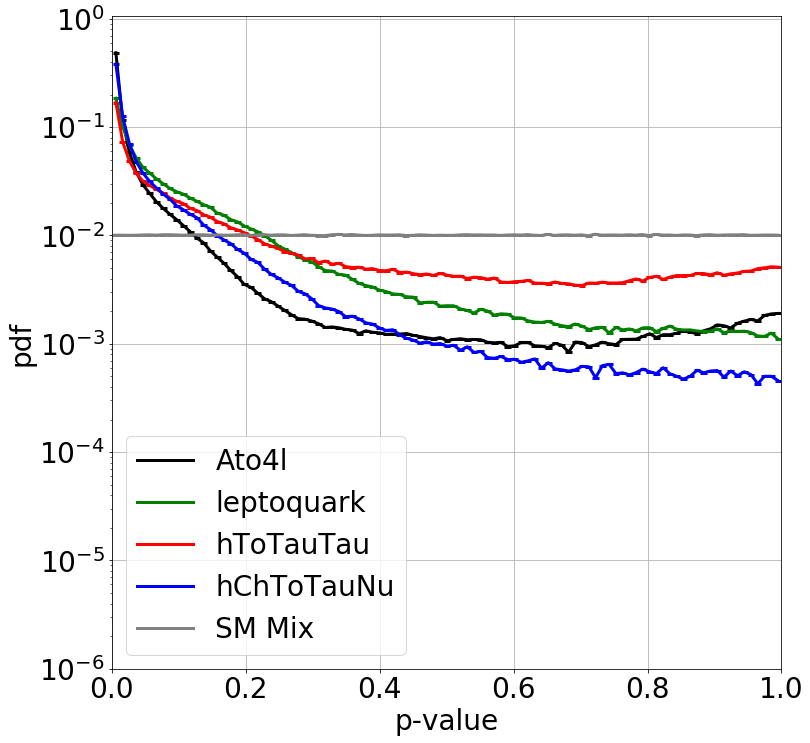

In [36]:
matplotlib.rcParams.update({'font.size': 28})

# p_SM = np.logspace(base=10, start=-7, stop=0, num=100)
# p_SM[-1] = 0.999
p_SM = np.linspace(start=1e-7, stop=0.999, num=100)

for ll in [1]: #range(3):
    f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(12,12))
#     ax_arr_ROC.plot([eff_SMMix, eff_SMMix], [1e-6, 1.05], color='m', lw=2, linestyle='--', label='1000 SM evts/month')
    ax_arr_ROC.set_xlim([1e-6, 1.0])
    ax_arr_ROC.set_ylim([1e-6, 1.05])
    ax_arr_ROC.set_xlabel('p-value', fontdict={'size': 28})
    ax_arr_ROC.ticklabel_format()
    ax_arr_ROC.set_ylabel('pdf', fontdict={'size': 28})
#     ax_arr_ROC.set_title('ROC VAE ' + Ytitles[ll], fontdict={'size': 16})
    ax_arr_ROC.set_yscale('log')
#     ax_arr_ROC.set_xscale('log')
    ax_arr_ROC.grid()

    t_SM = np.concatenate((loss_sig['Wlnu'][ll], 
                           loss_sig['qcd'][ll],
                           loss_sig['Zll'][ll],
                           loss_sig['ttbar'][ll]
                          ))
    
    w_SM = np.concatenate((np.full_like(loss_sig['Wlnu'][ll], weight[0], np.float128),
                           np.full_like(loss_sig['qcd'][ll], weight[1], np.float128),
                           np.full_like(loss_sig['Zll'][ll], weight[2], np.float128),
                           np.full_like(loss_sig['ttbar'][ll], weight[3], np.float128)
                          ))
    
    i_sort = np.argsort(t_SM)
    
    t_SM = t_SM[i_sort]
    w_SM = w_SM[i_sort]
    
    cum_sum = np.cumsum(w_SM, dtype=np.float128)/np.float128(l[i_min]/fraction[i_min])
    print 'CumSum accuracy:', cum_sum[-1]
    
    idx_q = np.argmax(cum_sum>np.atleast_2d(1-p_SM).T, axis=1)
    q_SM = np.flip(t_SM[idx_q], 0)
    
    for n in BSM_samples:
        
        val, bin_edges = np.histogram(loss_sig[n][ll], bins=q_SM)
        val = np.float64(val.astype(float)/loss_sig[n][ll].shape[0])
        print np.sum(val)
        bin_centers = 0.5*(p_SM[1:] + p_SM[:-1])
        bin_width = 0.5*(p_SM[1:] - p_SM[:-1])
        
        ax_arr_ROC.errorbar(1-bin_centers, val, xerr=bin_width, label=n, lw=3, color=BSM_colors[n])
        
    val, bin_edges = np.histogram(loss_train[ll], bins=q_SM)
    val = np.float64(val.astype(float)/loss_train[ll].shape[0])
    print np.sum(val)
    bin_centers = 0.5*(p_SM[1:] + p_SM[:-1])
    bin_width = 0.5*(p_SM[1:] - p_SM[:-1])
    ax_arr_ROC.errorbar(bin_centers, val, xerr=bin_width, label='SM Mix', lw=3, color='gray')
        
    ax_arr_ROC.legend(loc="best")
    f_ROC.savefig('../../fig/paper_fig/pValue_VAEv'+VAEversion+'_'+str(ll)+'.png')


In [31]:
p_SM = np.logspace(-5,-3, 3)

t_SM = np.concatenate((loss_sig['Wlnu'][ll], 
                       loss_sig['qcd'][ll],
                       loss_sig['Zll'][ll],
                       loss_sig['ttbar'][ll]
                      ))

w_SM = np.concatenate((np.full_like(loss_sig['Wlnu'][ll], weight[0], np.float128),
                       np.full_like(loss_sig['qcd'][ll], weight[1], np.float128),
                       np.full_like(loss_sig['Zll'][ll], weight[2], np.float128),
                       np.full_like(loss_sig['ttbar'][ll], weight[3], np.float128)
                      ))

i_sort = np.argsort(t_SM)

t_SM = t_SM[i_sort]
w_SM = w_SM[i_sort]

cum_sum = np.cumsum(w_SM, dtype=np.float128)/np.float128(l[i_min]/fraction[i_min])
print 'CumSum accuracy:', cum_sum[-1]

idx_q = np.argmax(cum_sum>np.atleast_2d(1-p_SM).T, axis=1)
q_SM = np.flip(t_SM[idx_q], 0)

print p_SM

for n in BSM_samples:
    out = loss_sig[n][ll] > np.atleast_2d(q_SM).T
    ev_BSM = np.sum(out, axis=1, dtype=np.float128)
    print n, ev_BSM



CumSum accuracy: 0.9999999999999475593
[1.e-05 1.e-04 1.e-03]
Ato4l [115931.  18580.   2397.]
leptoquark [16719.  2322.   486.]
hToTauTau [7589.  634.  159.]
hChToTauNu [20230.  1560.   475.]
